# Visual Word Sende Disambiguation

---

## 📘 Overview
Given a potentially ambiguous word and some limited textual context, the task is to select among a set of ten candidate images the one which corresponds to the intended meaning of the target word.

---

## 📝 Author
- **Luigi Gallo**  
  Email: [gallo.1895146@studenti.uniroma1.it](mailto:gallo.1895146@studenti.uniroma1.it)

---

In [1]:
TRAIN_DATA_DIR = 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train_images_v1'
TRAIN_DATA_FILE = {
    'en': 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.data.v1.txt'
}
TRAIN_GOLD_FILE = {
    'en': 'data/semeval-2023-task-1-V-WSD-train-v1/train_v1/train.gold.v1.txt'
}

TEST_DATA_DIR = 'data/test_images_resized'
TEST_DATA_FILE = {
    'en': 'data/test.data.v1.1.gold/en.test.data.v1.1.txt',
    'it': 'data/test.data.v1.1.gold/it.test.data.v1.1.txt',
    'fa': 'data/test.data.v1.1.gold/fa.test.data.v1.1.txt'
}
TEST_GOLD_FILE = {
    'en': 'data/test.data.v1.1.gold/en.test.gold.v1.1.txt',
    'it': 'data/test.data.v1.1.gold/it.test.gold.v1.1.txt',
    'fa': 'data/test.data.v1.1.gold/fa.test.gold.txt'
}

BATCH_SIZE = 64

In [2]:
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pandas as pd

# Set the random seed for reproducibility
torch.manual_seed(42)
# Enable TPU cores
torch.set_float32_matmul_precision('medium')

RESIZE_IMAGES = False

2024-02-13 10:12:10.016264: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 10:12:10.133501: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 10:12:10.133570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 10:12:10.148060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-13 10:12:10.187943: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Load TensorBoard extension
%load_ext tensorboard

In [67]:
# Import modules
from src.model import clip_proj, clip, clip_moco, clip_translator, clip_gpt, pretrained
from src.dataset import dataset
from src.utils import utils

# Reload all modules
import importlib
importlib.reload(dataset)
importlib.reload(utils)
importlib.reload(clip)
importlib.reload(clip_proj)
importlib.reload(clip_moco)
importlib.reload(clip_translator)
importlib.reload(clip_gpt)
importlib.reload(pretrained)

print("Modules reloaded!")

Modules reloaded!


## Dataset

In [5]:
if RESIZE_IMAGES:
    utils.resize_images(TRAIN_DATA_DIR)
    utils.resize_images(TEST_DATA_DIR)

In [6]:
# Define a transformation
transform = transforms.Compose([    
    transforms.Resize((224, 224)), 
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert all images to RGB
    transforms.ToTensor(),
])

# Create the train and test datasets
train_WSD_dataset = dataset.VisualWSDDatasetCLIP(
    data_dir=TRAIN_DATA_DIR,
    data_file=TRAIN_DATA_FILE,
    gold_file=TRAIN_GOLD_FILE,
    transform=transform,
    language='en')
test_WSD_dataset_en = dataset.VisualWSDDatasetCLIP(
    data_dir=TEST_DATA_DIR,
    data_file=TEST_DATA_FILE,
    gold_file=TEST_GOLD_FILE,
    transform=transform,
    language='en')
test_WSD_dataset_it = dataset.VisualWSDDatasetCLIP(
    data_dir=TEST_DATA_DIR,
    data_file=TEST_DATA_FILE,
    gold_file=TEST_GOLD_FILE,
    transform=transform,
    language='it')
test_WSD_dataset_fa = dataset.VisualWSDDatasetCLIP(
    data_dir=TEST_DATA_DIR,
    data_file=TEST_DATA_FILE,
    gold_file=TEST_GOLD_FILE,
    transform=transform,
    language='fa')

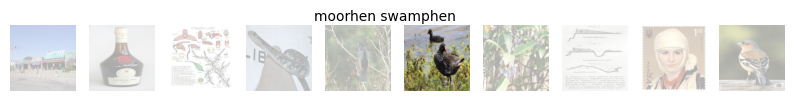

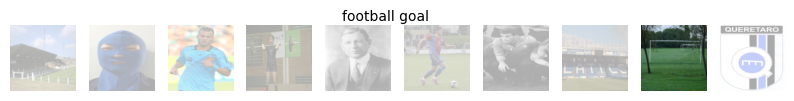

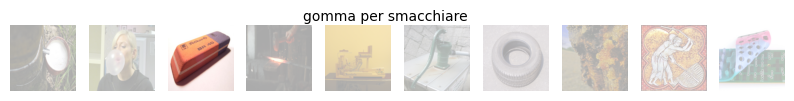

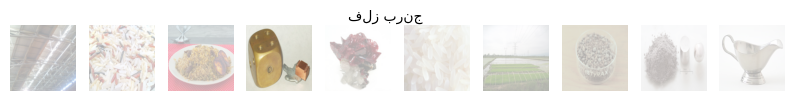

In [7]:
# Train samples
utils.display_samples(train_WSD_dataset, 1)

# Test samples
utils.display_samples(test_WSD_dataset_en, 1)
utils.display_samples(test_WSD_dataset_it, 1)
utils.display_samples(test_WSD_dataset_fa, 1)

In [8]:
# Define parameters
split_ratio = 0.8

# Calculate split sizes
calculate_split_sizes = lambda dataset_size, split_ratio: (int(split_ratio * dataset_size), dataset_size - int(split_ratio * dataset_size))

# Splitting the dataset
train_size, eval_size = calculate_split_sizes(len(train_WSD_dataset), split_ratio)
train_dataset, eval_dataset = random_split(train_WSD_dataset, [train_size, eval_size])

# Creating dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader_en = DataLoader(test_WSD_dataset_en, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader_it = DataLoader(test_WSD_dataset_it, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader_fa = DataLoader(test_WSD_dataset_fa, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

## Pretrained ResNet18 with DistillBERT

In [23]:
# Initialize model
res_bert = pretrained.VisualWSDModel()

In [24]:
# Training the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(res_bert, train_dataloader, val_dataloader)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type            | Params
---------------------------------------------------
0 | text_embedder  | DistilBertModel | 66.4 M
1 | image_embedder | ResNet          | 11.2 M
2 | text_proj      | Linear          | 98.4 K
3 | image_proj     | Linear          | 65.7 K
---------------------------------------------------
164 K     Trainable params
77.5 M    Non-trainable params
77.7 M    Total params
310.814   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reusing TensorBoard on port 6006 (pid 24946), started 1:26:25 ago. (Use '!kill 24946' to kill it.)

In [20]:
trainer = pl.Trainer()

trainer.test(model=res_bert, dataloaders=test_dataloader_en)
trainer.test(model=res_bert, dataloaders=test_dataloader_it)
trainer.test(model=res_bert, dataloaders=test_dataloader_fa)

print("Done!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.11231101304292679    │
│         test_mrr          │    0.2895933985710144     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.1147540956735611     │
│         test_mrr          │    0.2865677773952484     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.07999999821186066    │
│         test_mrr          │    0.3336944580078125     │
└───────────────────────────┴───────────────────────────┘

Done!


## CLIP

### Standard CLIP
This is the standard CLIP baseline

In [15]:
# Initialize model
clip_model = clip.ClipModel()

In [16]:
trainer = pl.Trainer()

trainer.test(model=clip_model, dataloaders=test_dataloader_en)
trainer.test(model=clip_model, dataloaders=test_dataloader_it)
trainer.test(model=clip_model, dataloaders=test_dataloader_fa)

print("Done!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.5745140314102173     │
│         test_mrr          │    0.34370821714401245    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.21639344096183777    │
│         test_mrr          │    0.28341662883758545    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.08500000089406967    │
│         test_mrr          │    0.29944443702697754    │
└───────────────────────────┴───────────────────────────┘

Done!


### CLIP with projection layers

In [9]:
# Initialize model
clip_proj_model = clip_proj.ClipModelProj()

In [10]:
# Training the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(clip_proj_model, train_dataloader, val_dataloader)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | clip_model  | CLIPModel | 151 M 
1 | vision_proj | Linear    | 65.7 K
2 | text_proj   | Linear    | 65.7 K
------------------------------------------
131 K     Trainable params
151 M     Non-trainable params
151 M     Total params
605.635   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


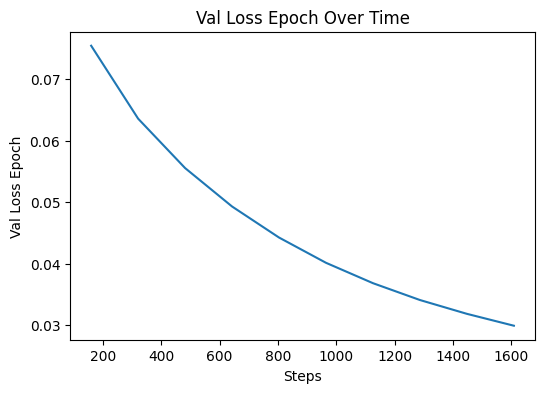

In [83]:
utils.plot_pl_logs('lightning_logs/version_52', 'val_loss_epoch', './plots/clip_proj')

In [11]:
trainer = pl.Trainer()

trainer.test(model=clip_proj_model, dataloaders=test_dataloader_en)
trainer.test(model=clip_proj_model, dataloaders=test_dataloader_it)
trainer.test(model=clip_proj_model, dataloaders=test_dataloader_fa)

print("Done!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.20518358051776886    │
│         test_mrr          │    0.31799080967903137    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.10819672048091888    │
│         test_mrr          │    0.28098103404045105    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.09999999403953552    │
│         test_mrr          │    0.2971309721469879     │
└───────────────────────────┴───────────────────────────┘

Done!


### CLIP with Momentum Contrastive (MoCo)

In [12]:
# Initialize model
clip_moco_model = clip_moco.ClipMocoModel()

In [13]:
# Training the model
trainer = pl.Trainer(max_epochs=10)
trainer.fit(clip_moco_model, train_dataloader, val_dataloader)

# Start TensorBoard within the notebook
%tensorboard --logdir lightning_logs/

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type      | Params
--------------------------------------------
0 | clip_model    | CLIPModel | 151 M 
1 | vision_proj   | Linear    | 65.7 K
2 | text_proj     | Linear    | 65.7 K
3 | clip_model_m  | CLIPModel | 151 M 
4 | vision_proj_m | Linear    | 65.7 K
5 | text_proj_m   | Linear    | 65.7 K
--------------------------------------------
262 K     Trainable params
302 M     Non-trainable params
302 M     Total params
1,211.269 Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reusing TensorBoard on port 6006 (pid 24946), started 0:56:42 ago. (Use '!kill 24946' to kill it.)

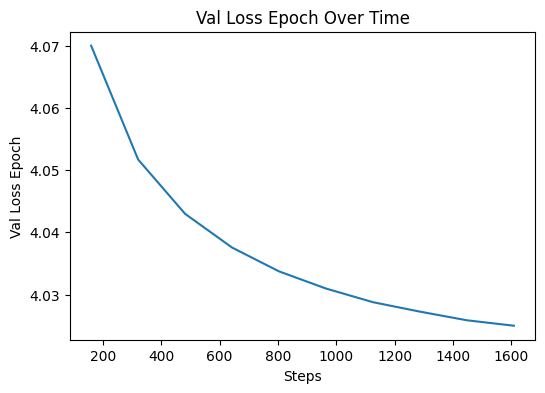

In [82]:
utils.plot_pl_logs('lightning_logs/version_54', 'val_loss_epoch', './plots/clip_moco')

In [14]:
trainer = pl.Trainer()

trainer.test(model=clip_moco_model, dataloaders=test_dataloader_en)
trainer.test(model=clip_moco_model, dataloaders=test_dataloader_it)
trainer.test(model=clip_moco_model, dataloaders=test_dataloader_fa)

print("Done!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.01727861724793911    │
│         test_mrr          │    0.07557118684053421    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │   0.026229508221149445    │
│         test_mrr          │    0.09531182050704956    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │   0.019999999552965164    │
│         test_mrr          │    0.07463560998439789    │
└───────────────────────────┴───────────────────────────┘

Done!


### CLIP with translator
In the aim to improve the CLIP baseline by solely acting on the input text, we add a translator that translates everything from the input language to english before feeding text into CLIP model.

In [56]:
# Initialize model
clip_trans = clip_translator.ClipModel()

In [18]:
trainer = pl.Trainer()

clip_trans.set_language('en')
trainer.test(model=clip_trans, dataloaders=test_dataloader_en)
clip_trans.set_language('it')
trainer.test(model=clip_trans, dataloaders=test_dataloader_it)
clip_trans.set_language('fa')
trainer.test(model=clip_trans, dataloaders=test_dataloader_fa)

print("Done!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.5745140314102173     │
│         test_mrr          │    0.34370821714401245    │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.5245901346206665     │
│         test_mrr          │     0.331307590007782     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.4399999976158142     │
│         test_mrr          │    0.3220674395561218     │
└───────────────────────────┴───────────────────────────┘

Done!


### Clip with translator and GPT 3.5 augumentation
For the augumentation we used GPT 3.5 with the following prompt:

`I need you to generate a short description of the apperance of the following items (the description should be in the same input language, <language> in this case) trying to be as general as possible (i.e. do not assume any specific color or shape of the item if the item may have different colors/shapes). You should produce a csv output with header (full_phrase,aspect) as a text I can copy, carefully paying attention not to put any commas in the description.  As a hint, please note that those descriptions will be fed into a CLIP model for a visual word sense disambiguation task (choose among 10 images the one that best match the description), so you should write it in the best way for this model to understand:`

Followed by a list of items in the original language. I decided to generate text in the original language so as to limit the possible introduction of further ambiguity (by first translating to english and then augmenting the text).

First, let's check the correctness of the generated dataframe to ensure all full_phrase are in the generated csv file:

In [9]:
languages = ['en', 'it', 'fa']

for lan in languages:
    print(f"\nTesting {lan.upper()} data:")
    
    # Read the data
    df1 = pd.read_csv(f'./data/test.data.v1.1.gold/{lan}.test.data.v1.1.txt', sep='\t', header=None, names=['target', 'full_phrase', 'image0', 'image1', 'image2', 'image3', 'image4', 'image5', 'image6', 'image7', 'image8', 'image9'])
    df2 = pd.read_csv(f'./data/gpt_data/gpt_{lan}_desc.csv')
    
    # Check for duplicates
    print(f"Duplicates {lan} in df1", len(df1[df1.duplicated(subset=['full_phrase'], keep=False)]))
    print(f"Duplicates {lan} in df2", len(df2[df2.duplicated(subset=['full_phrase'], keep=False)]))

    # Check for missing phrases
    print(f"There are {len(df1[~df1['full_phrase'].isin(df2['full_phrase'])])} missing phrases in {lan} df2 that are in df1")
    print(f"There are {len(df2[~df2['full_phrase'].isin(df1['full_phrase'])])} missing phrases in {lan} df1 that are in df2")


Testing EN data:
Duplicates en in df1 0
Duplicates en in df2 0
There are 0 missing phrases in en df2 that are in df1
There are 0 missing phrases in en df1 that are in df2

Testing IT data:
Duplicates it in df1 0
Duplicates it in df2 0
There are 0 missing phrases in it df2 that are in df1
There are 0 missing phrases in it df1 that are in df2

Testing FA data:
Duplicates fa in df1 0
Duplicates fa in df2 0
There are 0 missing phrases in fa df2 that are in df1
There are 0 missing phrases in fa df1 that are in df2


In [10]:
# Initialize model
clip_gpt_trans = clip_gpt.ClipModel('./data/gpt_data')

# Define the trainer
trainer = pl.Trainer()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
clip_gpt_trans.set_language('en')
trainer.test(model=clip_gpt_trans, dataloaders=test_dataloader_en)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.6047516465187073     │
│         test_mrr          │    0.3379383981227875     │
└───────────────────────────┴───────────────────────────┘

[{'test_h_at_1': 0.6047516465187073, 'test_mrr': 0.3379383981227875}]

In [14]:
clip_gpt_trans.set_language('it')
trainer.test(model=clip_gpt_trans, dataloaders=test_dataloader_it)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.5311475396156311     │
│         test_mrr          │    0.3160877227783203     │
└───────────────────────────┴───────────────────────────┘

[{'test_h_at_1': 0.5311475396156311, 'test_mrr': 0.3160877227783203}]

In [20]:
clip_gpt_trans.set_language('fa')
trainer.test(model=clip_gpt_trans, dataloaders=test_dataloader_fa)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_h_at_1        │    0.4099999964237213     │
│         test_mrr          │    0.2980218231678009     │
└───────────────────────────┴───────────────────────────┘

[{'test_h_at_1': 0.4099999964237213, 'test_mrr': 0.2980218231678009}]

## Output generation
I generate Farsi output using CLIP + translator model, while for English and Italian I use CLIP + GPT + translator model. That's because those are the one who performed best in the test scores (hit@1 metric).

In [60]:
for lan, dataloader in zip(['fa'], [test_dataloader_fa]):
    # Set the language
    clip_trans.set_language('fa')
    # Generate outputs
    utils.generate_output(clip_trans, lan, dataloader)

Testing fa data:   0%|          | 0/4 [00:00<?, ?it/s]

In [55]:
for lan, dataloader in zip(['en', 'it'], [test_dataloader_en, test_dataloader_it]):
    # Set the language
    clip_gpt_trans.set_language(lan)
    # Generate outputs
    utils.generate_output(clip_gpt_trans, lan, dataloader)

Testing en data:   0%|          | 0/8 [00:00<?, ?it/s]

Testing it data:   0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
# Compare files to verify congruence with hits@1 score
utils.compare_files('output/en.test.preds.txt', 'data/test.data.v1.1.gold/en.test.gold.v1.1.txt')
utils.compare_files('output/it.test.preds.txt', 'data/test.data.v1.1.gold/it.test.gold.v1.1.txt')
utils.compare_files('output/fa.test.preds.txt', 'data/test.data.v1.1.gold/fa.test.gold.txt')


Matching Lines Ratio: 0.60 (280/463)
Matching Lines Ratio: 0.53 (162/305)
Matching Lines Ratio: 0.44 (88/200)
